#### https://online.stat.psu.edu/stat505/lesson/10

Discriminant analysis is a classification problem. Two or more groups have known distributions. Now we get a data point. We want to classify it into one group.

We are interested in the conditional probabiliy that an observation came from population $\pi_i$ given the observed values of the multivarite vector of variables **x**
$$
P(\pi_i|x)
$$

Use bayes rule, we can calculate
$$
P(\pi_i|x) = \frac{P(x, \pi_i)}{P(x)} = \frac{f(x|\pi_i) P(\pi_i)}{P(x)}
$$

Given a new observation x, and suppose we have 2 groups $\pi_1$ and $\pi_2$, we'd like to calculate
$$
P(\pi_1|x) = \frac{f(x|\pi_1) p_1}{P(X)}
$$
and 
$$
P(\pi_2|x) = \frac{f(x|\pi_2) p_2}{P(X)}
$$

Make a comparison and see which one is more likely, i.e. comparing
$
f(x|\pi_1) p_1 
$
vs.
$
f(x|\pi_2) p_2
$

Mostly, it's easier to take log to make a comparison, since it converts multiplication into addition, and it preserves mononicity
$$
log(f(x|\pi_i)) + log(p_i)
$$

#### Linear Discriminant Analysis

We assume that in population $\pi_i$, the pdf of x is multivariate normal with mean vector $\mu_i$ and cov mat $\Sigma$. For now, let's assume the mean vectors vary while the cov mat is the same for all populations. Then
$$
f(x|\pi_i) = \frac{1}{\sqrt{2\pi}^p |\Sigma|^{0.5}} exp(-\frac{1}{2} (x-\mu_i)^T \Sigma^{-1} (x-\mu_i))
$$

We take log, ignoring some terms:
$$
log(f(x|\pi_i)) = -\frac{1}{2} \mu_i^T \Sigma^{-1} \mu_i + \mu_i^T \Sigma^{-1} x
$$

Therefore, the Linear Score function becomes:
$$
s_i(X) = -\frac{1}{2} \mu_i^T \Sigma^{-1} \mu_i + \mu_i^T \Sigma^{-1} x + log{p_i}
$$

Intuition about the formula:
<ol>
    <li>$\mu_i$ is p x 1, and $\Sigma$ is p x p</li>
    <li>The first term is a scaler, depending on which population it is</li>
    <li>The second term is a linear combination of x, for example if we have 9 x-variables, it is $b_1 x_1 + b_2 x_2 + ... + b_9 x_9$</li>
    <li>THe last term is the prior probability; this is a bias we hold in favor of populations with higher probability.</li>
</ol>

The ultimate goal is to compute the linear score functions for all potential populations given an observation. To do so, we need to estimate parameters:
<ol>
<li>$p_i$: prior probabilities</li>
<li>$\mu_i$: the population means estimated by the sample mean vector</li>
<li>$\Sigma$: the cov matrix estimated by the pooled sample cov mat</li>
</ol>

Let S_i denote the sample cov mat for population i. Then the estimated covmat is:
$$
S_p = \frac{\sum_{i=1}^g (n_i - 1) S_i}{\sum_{i=1}^g (n_i - 1)}
$$

#### LDA example: Insect Data

We have 2 species of insects: a, b. Three variabels were measured on each insect: width of the 1st joint, width of the 2nd joint, width of the organ. We have 10 individuals of each species to make up training data.

In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("insect.txt", delim_whitespace=True, header=None)

In [6]:
df.columns = ['species', 'firstjoint', 'secondjoint', 'organ']

**Specify the prior probabilities**: we do not have any information here, so we assume equal weight, i.e. $p_1 = p_2 = 0.5$ 

Test for homogeneity of the cov mat using **Bartlett's test**. We will talk about it later.

Estimate $\mu_1$ and $\mu_2$

In [13]:
df.groupby('species').mean()

,firstjoint,secondjoint,organ
species,,,
a,179.1,128.4,50.5
b,208.2,122.8,48.9


In [14]:
tmp = df.groupby('species').mean()
mu1, mu2 = tmp.loc['a'], tmp.loc['b']

Estimate $\Sigma$

In [23]:
tmp = df.groupby('species').cov()
cov1, cov2 = tmp.loc['a'], tmp.loc['b']
covmat = (cov1+cov2)/2
covmat

,firstjoint,secondjoint,organ
firstjoint,231.250000,87.333333,34.150000
secondjoint,87.333333,81.888889,11.655556
organ,34.150000,11.655556,7.411111


Now we can make the desired linear score functions
$$
s_i(X) = -\frac{1}{2} \mu_i^T \Sigma^{-1} \mu_i + \mu_i^T \Sigma^{-1} x + log{p_i}
$$

In [24]:
inv_covmat = np.linalg.inv(covmat)

In [36]:
term1a = mu1.T @ inv_covmat @ mu1 / -2
term2a = mu1.T @ inv_covmat

In [39]:
term1b = mu2.T @ inv_covmat @ mu2 / -2
term2b = mu2.T @ inv_covmat

In [37]:
term1a

-247.2762371667988

In [38]:
term2a

array([-1.41735821,  1.52045067, 10.95396958])

It means the linear score function for the first group is
$$
s_1(x) = -247.2762371667988 - 1.41735821 x_1 + 1.52045067 x_2 + 10.95396958 x_3
$$

In [40]:
term1b

-193.17839685457972

In [41]:
term2b

array([-0.73813285,  1.11259161,  8.2496892 ])

It means the linear score function for the first group is
$$
s_2(x) = -193.17839685457972 - 0.73813285 x_1 + 1.11259161 x_2 + 8.2496892 x_3
$$

Good, let's now look at how it performs in the training data:

In [43]:
df[df['species']=='a']

,species,firstjoint,secondjoint,organ
0,a,191,131,53
1,a,185,134,50
2,a,200,137,52
3,a,173,127,50
4,a,171,128,49
5,a,160,118,47
6,a,188,134,54
7,a,186,129,51
8,a,174,131,52
9,a,163,115,47


In [45]:
Xa = df[df['species']=='a'].iloc[:, -3:]

In [52]:
# The scores of classifying into group a
score_a_a = term1a + Xa @ term2a

In [51]:
score_a_b = term1b + Xa @ term2b

Ok, looks like our model does well to classify **a** specifies as **a**

In [54]:
score_a_a > score_a_b

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

Now, consider an insect with the following measurements: joint 1 = 194, joint2 = 124, organ = 49

In [55]:
term1a + np.array([194, 124, 49]) @ term2a

203.0366624787756

In [56]:
term1b + np.array([194, 124, 49]) @ term2b

205.8199621156291

Hence, we classify this into species **b**

As to the actual probabilities, we should refer to this formula:

$$
P(\pi_1|x) = \frac{f(x|\pi_1) p_1}{P(X)}
$$

In [70]:
one = np.exp(203.0366624787756) * 0.5 
two = np.exp(205.8199621156291) * 0.5
print("According to our model, this observation has {0:.2%} probability \nto be classified as species A, and {1:.2%} probability as B".format(one / (one + two), two / (one + two)))

According to our model, this observation has 5.82% probability 
to be classified as species A, and 94.18% probability as B


#### We have 3 things left: Why do we need Bartlett's test? We have training data, how about (cross) validation? In addition to Linear DA, we also have Quadratic DA.

#### Bartlett's test

In [71]:
from IPython.display import Image

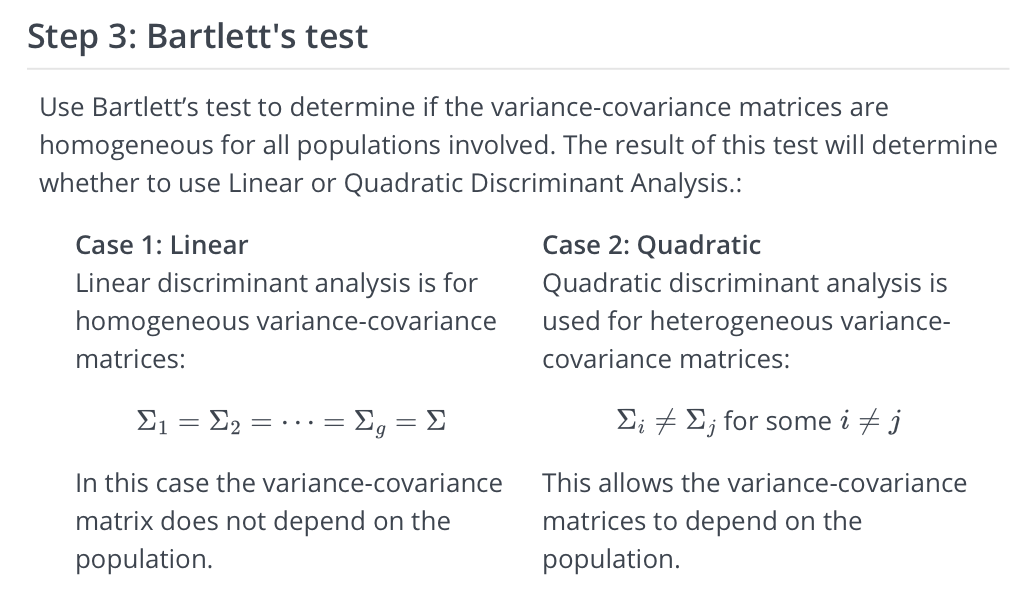

In [72]:
Image("Bartlett_test.png", width=600, height=600)

#### Confusion Matrix

$\;\;\;\;\;\;$$\;\;\;\;\;\;$$\;\;\;\;\;\;$$\;\;\;\;\;\;$ Actual <br>
$\;\;\;\;\;\;$$\;\;\;\;\;\;$$\;\;\;\;\;\;$$\;\;\;\;\;\;$True False <br>
Model$\;\;\;\;\;\;$True$\;\;\;\;$ NICE $\;\;$II <br>
$\;\;\;\;\;\;$$\;\;\;\;\;\;\;\;$False$\;\;\;\;\;\;$I$\;\;\;$NICE

If Actual = True, Model = True -> Model is good <br>
If Actual = False, Model = False -> Model is good too <br>

If Actual = True, Model = False -> type I error <br>
If ACtual = False, Model = True -> type II error

Example 1: True is guilty, False is not guilty <br>
What is type I, II error? Which one is worse?

Example 2: True is diagonosed with cancer, False is not <br>
What is type I, II error? Which one is worse?

Usually we need a tradeoff between type I and type II errors

Example 3: True is hypothesis test is true, False is false <br>
What is type I, II error? <br>
Confidence Level, p-value, ... are all about type I error

Example 4: True is species A, False is species B <br>
What is type I, II error?

#### Linear Discriminant Analysis: Package

In [78]:
pd.get_dummies(df['species'])

,a,b
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [79]:
X = df.iloc[:,-3:]
y = pd.get_dummies(df['species'])['a']

In [80]:
clf = LinearDiscriminantAnalysis(priors=[0.5, 0.5])

In [81]:
clf.fit(X, y)

LinearDiscriminantAnalysis(priors=[0.5, 0.5])

In [84]:
clf.priors_

array([0.5, 0.5])

In [83]:
clf.means_

array([[208.2, 122.8,  48.9],
       [179.1, 128.4,  50.5]])

In [92]:
clf.predict(np.array([194, 124, 49]).reshape(1,-1))

array([0], dtype=uint8)

In [93]:
clf.predict_proba(np.array([194, 124, 49]).reshape(1,-1))

array([[0.94176667, 0.05823333]])

In [97]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score

In [103]:
confusion_matrix(y, clf.predict(X))

array([[10,  0],
       [ 0, 10]])

In [104]:
print(classification_report(y, clf.predict(X), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      1.000     1.000     1.000        10

    accuracy                          1.000        20
   macro avg      1.000     1.000     1.000        20
weighted avg      1.000     1.000     1.000        20



Notice that here we have only one set of intercept and coef. Why?

In [95]:
clf.intercept_

array([-54.09784031])

In [94]:
clf.coef_

array([[-0.67922537,  0.40785906,  2.70428038]])

It's called "Decision Boundary". We won't touch this but this is the core of all kinds of Classification algos.